In [1]:
import numpy as np
import scipy.stats
import os
import re

import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.multitest
import seaborn as sns

import csv
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Define file paths
data_dir = '../data'
pupil_dir = '../data/SingleTrialPupilData'
eeg_dir = '../data/SingleTrialEEGData'
plot_dir = '../plots'

## Model Fitting

Skip if loading previously fitted data
- Fit to mean pupil dilation for "included" trials

In [ ]:
files_pupil = os.listdir(pupil_dir)
files_eeg = os.listdir(eeg_dir)

In [ ]:
def function(lr, file, V_0):

    """
    Updates and computes the correlation between V values and mean EEG frequency data.
    
    Parameters:
        - lr (float): 
            Learning rate for updating V values.
        - file (str): 
            Filename of the pupil data CSV.
        - V_0 (list or array): 
            Initial V values.
    
    Returns:
        float: Negative Pearson correlation coefficient between updated V values and mean EEG frequencies.
    """

    # Extract participant identifier from the filename
    res = re.search('(...)_PupilDiameterProcessed', file)
    participant = res.group(1)

    # Find the corresponding EEG file
    match_eeg = [s for s in files_eeg if participant in s]

    # Load the pupil and EEG data
    df_pupil = pd.read_csv(os.path.join(pupil_dir, file))
    df_eeg = pd.read_csv(os.path.join(eeg_dir, match_eeg[0]))

    # Calculate the cumulative number of trials up to each block
    block_1 = np.sum(df_eeg['Block'] == 1)
    block_2 = block_1 + np.sum(df_eeg['Block'] == 2)
    block_3 = block_2 + np.sum(df_eeg['Block'] == 3)
    block_4 = block_3 + np.sum(df_eeg['Block'] == 4)

    # Calculate the mean pupil diameter for each trial
    mean_pupil = np.array(np.mean(df_pupil.loc[:,'0':'3299'], axis = 1))
    df_pupil['means'] = mean_pupil

    # Recode 'side' as numerical values
        # 'side' refers to the direction of the rock
    df_pupil['side'] = (df_pupil['start_new_trial_condition']== 'Left') * 0 + (
        df_pupil['start_new_trial_condition']== 'MiddleLow') * 1 + (
        df_pupil['start_new_trial_condition']== 'Right') * 2 # Recode side as numbers

    # Initialize V values
    V = np.array((V_0))
    all_V = np.zeros((np.shape(df_eeg)[0] + 1, 3))
    all_V[0, :] = V

    # Calculate V values for each trial across blocks
    for block in [1,2,3,4]:

        # Skip block 3 for participant 5, as pain values are missing
        if participant == 'P05' and (block == 3 or block == 4):
            continue
        if participant == 'P14' and block == 4:
            continue
        
        # Get data for block
        this_block = df_eeg[df_eeg['Block'] == block]

        # Update V values for each trial
        for i_t, trial in enumerate(this_block['epoch']):

            # Determine cue side based on 'type'
            if this_block.loc[trial-1, 'type'] == 'left':
                cue_side = 0
            elif this_block.loc[trial-1, 'type'] == 'middle':
                cue_side = 1
            elif this_block.loc[trial-1, 'type'] == 'right':
                cue_side = 2
            else:
                print('Error: Unrecognized cue side.')

            # Determine reward value based on 'pain'
            if this_block.loc[trial-1,'pain'] == 'PCollShock':
                r = 1
            elif this_block.loc[trial-1,'pain'] == 'nPCollNoShock':
                r = 0
            elif this_block.loc[trial-1,'pain'] == 'PCollNoShock':
                r = 0
            elif np.logical_and(np.isnan(this_block.loc[trial-1,'pain']), block == 2 or block == 4):
                r = 0
            else:
                if this_block.loc[trial-1, 'type'] == 'middle':
                    r = 0
                else:
                    r = 1

            # Update V
            V[cue_side] = V[cue_side] * (1 - lr) + lr * r
            all_V[trial, :] = V
    
    # Create a mask to exclude the last trial
    V_incl = ~np.all(df_pupil.loc[:,'0':'3299'] == 0, axis = 1) # Find trials with no missing pupil
    V_incl[np.shape(V_incl)[0] + 1] = False
    pupil_incl = ~np.all(df_pupil.loc[:,'0':'3299'] == 0, axis = 1) # Find trials with no missing data
    
    
    # Exclude the last trials for participant 5 and 14, as pain values are missing
    if participant == 'P05':
        pupil_incl[180::] = False
        V_incl[180::] = False
    elif participant == 'P14':
        pupil_incl[241::] = False
        V_incl[241::] = False

    # Calculate the correlation between V values and mean pupil diameter
    correlation = scipy.stats.pearsonr(
                all_V[V_incl, df_pupil.loc[pupil_incl, 'side']],
                df_pupil.loc[pupil_incl, 'means'])[0]

    return (-correlation)

In [ ]:
all_tonic_sides = pd.read_csv(os.path.join(data_dir, 'tonicpainsides.csv'))

In [ ]:
# Define boundary constraints for optimization. 
# Lower bound (lb) is set to 0.0 and upper bound (ub) is set to 1.0.
bnds = scipy.optimize.Bounds(lb=0.01, ub=0.99)

In [ ]:
# Intialize DataFrame to save relevant trial data (pupil, V values, participant ID, and congruency)
all_data = pd.DataFrame()

# Intialize DataFrame to save relevant model fitting data (ID, learning rate, maximum correlation)
df_model = pd.DataFrame()

for i_file, file in enumerate(files_pupil):
    print('========= \n File : {} of {}'.format(i_file + 1, len(files_pupil)))
    try:

        # Initialize V Values for RL
        V_0 = np.array((1/3, 1/3, 1/3)) #np.zeros((3))
        
        # Extract the participant ID from the file name
        ID = int(re.split('_PupilDiameterProcessed_ST.csv', file)[0][1::])

        # Extract the tonic pain sides for the participant
        tonic_sides  = all_tonic_sides.loc[all_tonic_sides['ID'] == ID, 'Extn1' : 'Extn2'].values[0].astype('str')
        tonic_sides[np.where(tonic_sides == '1')] = 'left'
        tonic_sides[np.where(tonic_sides == '2')] = 'right'
        
        # Fit the model
        fit_res = scipy.optimize.minimize(function, (0.5, ), args=(file, V_0), method= 'SLSQP', bounds = bnds)
        print(fit_res.message)
        
        # Extract participant identifier from the filename
        res_file = re.search('(...)_PupilDiameterProcessed', file)
        participant = res_file.group(1)

        # Find the corresponding EEG file
        match_eeg = [s for s in files_eeg if participant in s]

        # Load pupil and EEG data
        df_pupil = pd.read_csv(os.path.join(pupil_dir, file))
        df_eeg = pd.read_csv(os.path.join(eeg_dir, match_eeg[0]))


        # Recode 'side' as numerical values
            # 'side' refers to the direction of the rock
        df_eeg['side'] = (df_eeg['type']== 'left') * 0 + \
            (df_eeg['type']== 'middle') * 1 + \
            (df_eeg['type']== 'right') * 2

        # Calculate the mean pupil diameter for each trial and timebin
        timebin_1 = np.array(np.mean(df_pupil.loc[:,'0':'799'], axis = 1))
        timebin_2 = np.array(np.mean(df_pupil.loc[:,'800':'1799'], axis = 1))
        timebin_3 = np.array(np.mean(df_pupil.loc[:,'1800':'2799'], axis = 1))
        timebin_4 = np.array(np.mean(df_pupil.loc[:,'2800':'3299'], axis = 1))

        df_pupil['t1'] = timebin_1
        df_pupil['t2'] = timebin_2
        df_pupil['t3'] = timebin_3
        df_pupil['t4'] = timebin_4
        
        # Initialize V values
        V = np.array((V_0))
        all_V = np.zeros((np.shape(df_eeg)[0] + 1, 3))
        all_V[0, :] = V
        
        # Save learning rate from model fitting
        lr = fit_res.x
        
        # Calculate V values for each trial across blocks
        for block in [1,2,3,4]:

            # Skip block 3 for participant 5, as pain values are missing
            if ID == 5 and (block == 3 or block == 4):
                print('Skipping block 3 and 4 for participant 5')
                continue
            if ID == 14 and block == 4:
                print('Skipping block 4 for participant 14')
                continue
            
            # Extract data for block
            this_block = df_eeg[df_eeg['Block'] == block]

            # Loop over trials and update V values
            for i_t, trial in enumerate(this_block['epoch']):

                if ID == 14 and trial>241:
                    print('Skipping trial {} in block 3 for participant 14'.format(trial))
                    continue

                # Determine cue side based on 'type'
                if this_block.loc[trial-1, 'type'] == 'left':
                    cue_side = 0
                elif this_block.loc[trial-1, 'type'] == 'middle':
                    cue_side = 1
                elif this_block.loc[trial-1, 'type'] == 'right':
                    cue_side = 2
                else:
                    print('what is going on with the cue sides?')


                # Determine reward value based on 'pain'
                if this_block.loc[trial-1,'pain'] == 'PCollShock':
                    r = 1
                elif this_block.loc[trial-1,'pain'] == 'nPCollNoShock':
                    r = 0
                elif this_block.loc[trial-1,'pain'] == 'PCollNoShock':
                    r = 0
                elif np.logical_and(np.isnan(this_block.loc[trial-1,'pain']), block == 2 or block == 4):
                    r = 0
                else:
                    print('Error: Unrecognized pain value: {}'.format(this_block.loc[trial-1,'pain']))
                    if this_block.loc[trial-1, 'type'] == 'middle':
                        r = 0
                    else:
                        r = 1
                
                # Update V based on reward and learning rate
                V[cue_side] = V[cue_side] * (1 - lr) + lr * r
                all_V[trial, :] = V
        
        # Create a mask for which trials to include
        V_incl = ~np.all(df_pupil.loc[:,'0':'3299'] == 0, axis = 1)
        V_incl[np.shape(V_incl)[0] + 1] = False
        pupil_incl = ~np.all(df_pupil.loc[:,'0':'3299'] == 0, axis = 1)

        # Exclude the last trials for participant 5 and 14, as pain values are missing
        if participant == 'P05':
            pupil_incl[180::] = False
            V_incl[180::] = False
        elif participant == 'P14':
            pupil_incl[241::] = False
            V_incl[241::] = False

        # Create a DataFrame for the V values for the included trials
        df_V = pd.DataFrame(all_V[
            V_incl, 
            df_eeg.loc[pupil_incl, 'side']],
            columns = ['V'])

        # Create a DataFrame for the participant ID (repeated for each trial)
        df_ID = pd.DataFrame(np.repeat(ID, np.shape(df_V)[0]), columns = ['ID'])

        # Filter the pupil data
        df_pupil_in = df_pupil.loc[pupil_incl, 't1': 't4']
        
        # Congruency Information
        cong = np.logical_or(
            np.logical_and(df_eeg['Block'] == 2, df_eeg['type'] == tonic_sides[0]),
            np.logical_and(df_eeg['Block'] == 4, df_eeg['type'] == tonic_sides[1]))
        incong = np.logical_or(
            np.logical_and(df_eeg['Block'] == 2, df_eeg['type'] == tonic_sides[1]),
            np.logical_and(df_eeg['Block'] == 4, df_eeg['type'] == tonic_sides[0]))

        # Create a DataFrame for congruency information (congruent or incongruent on extinction blocks; nan for acquisition blocks)
        df_congr = (np.ones((np.shape(df_eeg)[0])) * np.nan).astype('str')
        df_congr[cong] = "congr" # congruent
        df_congr[incong] = "incongr" # incongruent

        # Filter congruency data for included trials
        df_congr = pd.DataFrame(df_congr[pupil_incl], columns = ['congruency'])
                
        # Add to dataframe
        new_row = pd.concat([df_pupil_in.reset_index(drop = True),df_V, df_ID, df_congr], axis = 1)
        all_data = pd.concat([all_data, new_row])

        # Append the model fitting data
        df_model = pd.concat([df_model, pd.DataFrame({'ID': ID, 'lr': lr, 'max_corr': -fit_res.fun})])
        
    except:
        print('__something went wrong')
    

all_data = all_data.reset_index(drop = True)

print('DONE')

In [ ]:
df_model.to_csv(os.path.join(data_dir, 'pupil_model_fitting_results.csv'), index = False)

In [ ]:
# Check DataFrame
all_data

In [ ]:
all_data.to_csv(os.path.join(data_dir, 'pupil_v_values.csv'), index = False)

## Load Data

In [4]:
# Read csv file into DataFrame
all_data = pd.read_csv(os.path.join(data_dir, 'pupil_v_values.csv'))

## Regression

In [5]:
# Reshape the 'all_data' DataFrame from wide to long format, using 'ID', 'V', and 'congruency' as identifier variables.
dat = pd.melt(all_data, id_vars = ['ID','V', 'congruency'], var_name = 'timebin', value_name = 'pupil')
dat['ID'] = dat['ID'].astype('object')

# Convert 'timebin' to an ordered categorical type
time_bin_order = ['t1', 't2', 't3', 't4']
dat['timebin'] = pd.Categorical(dat['timebin'], categories=time_bin_order, ordered=True)

# Convert 'ID' into a categorical
dat['ID'] = pd.Categorical(dat['ID'], ordered = False)

# Add z scores
dat['z_score_pupil'] = scipy.stats.zscore(dat['pupil'])

/var/folders/v4/1zbrx95516919mf320cfydlh0000gn/T/ipykernel_54493/2226833611.py:10: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dat['ID'] = pd.Categorical(dat['ID'], ordered = False)


Get rid of values with a zscore of |z| > 3, gets rid of 701 outliers (2% of data)

In [6]:
dat = dat.loc[abs(dat['z_score_pupil'])<3, "ID": "pupil"]
dat

,ID,V,congruency,timebin,pupil
0,22,0.333333,NaN,t1,-0.057937
1,22,0.333333,NaN,t1,0.007286
2,22,0.178075,NaN,t1,-0.065928
3,22,0.333333,NaN,t1,0.040220
4,22,0.178075,NaN,t1,-0.188147
...,...,...,...,...,...
35942,15,0.101820,NaN,t4,-0.470178
35943,15,0.100801,NaN,t4,-0.122699
35944,15,0.300519,congr,t4,0.020342
35945,15,0.283608,incongr,t4,0.476715


## Assumption Check

/var/folders/v4/1zbrx95516919mf320cfydlh0000gn/T/ipykernel_54493/3218353808.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  var_corr = dat.corr()


<Axes: >

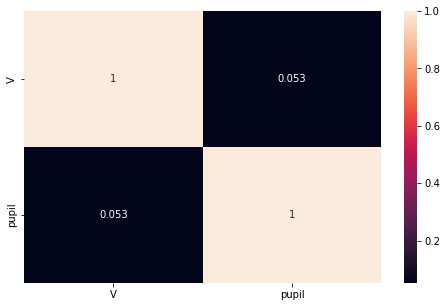

In [7]:
# get table of variable correlations
var_corr = dat.corr()
# plot the heatmap
sns.heatmap(var_corr, xticklabels=var_corr.columns, yticklabels=var_corr.columns, annot=True)

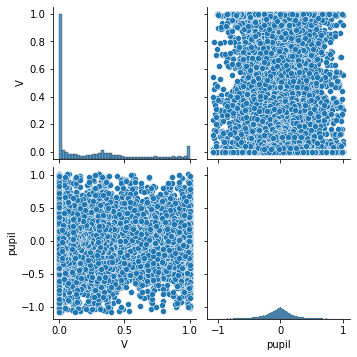

In [8]:
sns.pairplot(dat)

### Pupil ~ V * timebin

In [9]:
# Performing an ordinary least squares (OLS) regression analysis, modeling 'pupil' as a function of 'V' and 'timebin',including their interaction
res = smf.ols('pupil ~ V * timebin', data = dat).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pupil   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     155.7
Date:                Mon, 27 Jan 2025   Prob (F-statistic):          1.53e-227
Time:                        22:09:41   Log-Likelihood:                -2895.9
No. Observations:               35247   AIC:                             5808.
Df Residuals:                   35239   BIC:                             5875.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0080      0.003     -2.303      0.021      -0.015      -0.001
timebin[T.t2]      -0.0950      0.005    -19.323      0.000      -0.105      -0.085
timebin[T.t3]      -0.0402      0.005     -8.181      0.000      -0.050      -0.031
timebin[T.t4]      -0.0014      0.005     -0.288      0.773      -0.011       0.008
V                  -0.0005      0.009     -0.059      0.953      -0.018       0.017
V:timebin[T.t2]     0.0193      0.013      1.513      0.130      -0.006       0.044
V:timebin[T.t3]     0.0619      0.013      4.862      0.000       0.037       0.087
V:timebin[T.t4]     0.1031      0.013      8.099      0.000       0.078       0.128
==============================================================================
Omnibus:                     1824.220   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6988.560
Skew:                          -0.076   Prob(JB):                         0.00
Kurtosis:                       5.176   Cond. No.                         16.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# Extract the p-values from the OLS regression result.
p_values = res.pvalues 

# Perform multiple hypothesis testing correction on the p-values using the Benjamini-Hochberg method (FDR correction), with a significance level (alpha) of 0.05.
_, pvals_corrected, _, _ = statsmodels.stats.multitest.multipletests(p_values, alpha=0.05, method='fdr_bh')

# Convert the original and corrected p-values to a DataFrame for better visualization.
df_stats = pd.DataFrame(res.summary().tables[1])
df_stats.set_index(df_stats.columns[0], inplace=True)
df_stats.columns = df_stats.iloc[0]
df_stats = df_stats[1:]
#dat_p = p_values.to_frame()
df_stats.insert(6, "corrected", pvals_corrected)

# Save the DataFrame to an Excel file.
df_stats.to_excel("output_pupil_V-timebin.xlsx", index = True)
df_stats

,coef,std err,t,P>|t|,[0.025,0.975],corrected
0,,,,,,,
Intercept,-0.0080,0.003,-2.303,0.021,-0.015,-0.001,3.401349e-02
timebin[T.t2],-0.0950,0.005,-19.323,0.000,-0.105,-0.085,7.431686e-82
timebin[T.t3],-0.0402,0.005,-8.181,0.000,-0.050,-0.031,1.160034e-15
timebin[T.t4],-0.0014,0.005,-0.288,0.773,-0.011,0.008,8.838155e-01
V,-0.0005,0.009,-0.059,0.953,-0.018,0.017,9.531476e-01
V:timebin[T.t2],0.0193,0.013,1.513,0.130,-0.006,0.044,1.736671e-01
V:timebin[T.t3],0.0619,0.013,4.862,0.000,0.037,0.087,2.332452e-06
V:timebin[T.t4],0.1031,0.013,8.099,0.000,0.078,0.128,1.519697e-15


In [11]:
# Convert the original and corrected p-values to a DataFrame for better visualization.
df_stats = pd.DataFrame(res.summary().tables[0])
df_stats.set_index(df_stats.columns[0], inplace=True)
df_stats.columns = df_stats.iloc[0]
df_stats = df_stats[1:]
# Save the DataFrame to an Excel file.
df_stats.to_excel("output_model_param - pupil-V-timebin.xlsx", index = True)
df_stats

Dep. Variable:,pupil,R-squared:,0.030
0,,,
Model:,OLS,Adj. R-squared:,0.030
Method:,Least Squares,F-statistic:,155.7
Date:,"Mon, 27 Jan 2025",Prob (F-statistic):,1.53e-227
Time:,22:09:41,Log-Likelihood:,-2895.9
No. Observations:,35247,AIC:,5808.
Df Residuals:,35239,BIC:,5875.
Df Model:,7,,
Covariance Type:,nonrobust,,


### Assumption Check

**Check for Homoscedasticity**

Text(0, 0.5, 'residuals')

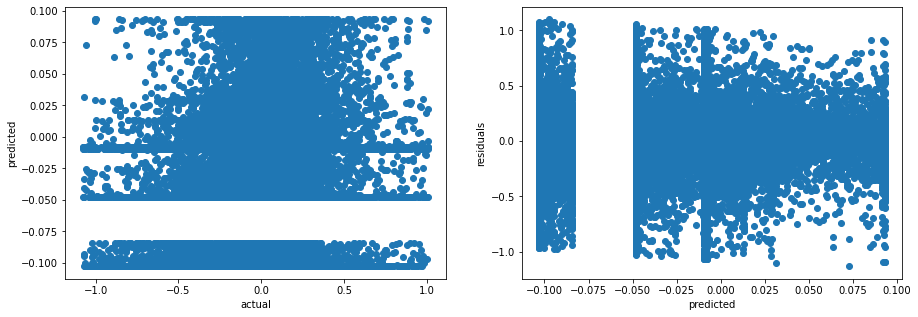

In [12]:
x_dat = dat[['V', 'timebin']]
y_dat = dat['pupil']


predicted = res.predict(x_dat)
residuals = y_dat - predicted

f, axs = plt.subplots(1, 2, figsize = [15,5])

axs[0].scatter(y_dat, predicted)
axs[0].set_xlabel('actual')
axs[0].set_ylabel('predicted')

axs[1].scatter(predicted, residuals)
axs[1].set_xlabel('predicted')
axs[1].set_ylabel('residuals')



**Check for Normality of residuals**

/var/folders/v4/1zbrx95516919mf320cfydlh0000gn/T/ipykernel_54493/1540356105.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals,kde=True)


Text(0.5, 1.0, 'Normality of error terms/residuals')

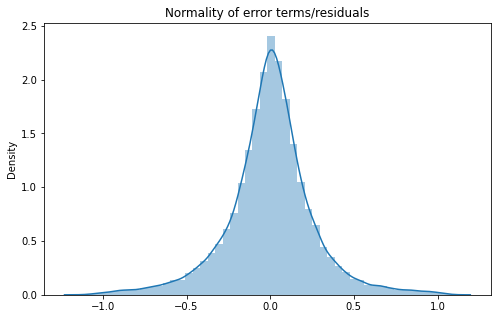

In [13]:
sns.distplot(residuals,kde=True)
plt.title('Normality of error terms/residuals')

### Pupil ~ V*congruency

In [14]:
i_ext = [False if (x is not str(x) and np.isnan(x)) else True for x in dat['congruency'].values]
dat_cong = dat[i_ext]

res = smf.ols("pupil ~ V*C(congruency, Treatment(reference = 'incongr'))", data = dat_cong).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pupil   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     9.843
Date:                Mon, 27 Jan 2025   Prob (F-statistic):           1.76e-06
Time:                        22:09:42   Log-Likelihood:                -1526.1
No. Observations:               13921   AIC:                             3060.
Df Residuals:                   13917   BIC:                             3090.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                   -0.0505      0.004    -13.027      0.000      -0.058      -0.043
C(congruency, Treatment(reference='incongr'))[T.congr]       0.0091      0.005      1.666      0.096      -0.002       0.020
V                                                            0.0558      0.017      3.370      0.001       0.023       0.088
V:C(congruency, Treatment(reference='incongr'))[T.congr]     0.0062      0.024      0.265      0.791      -0.040       0.052
==============================================================================
Omnibus:                      705.317   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2640.295
Skew:                          -0.074   Prob(JB):                         0.00
Kurtosis:                       5.128   Cond. No.                         13.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# Extract the p-values from the OLS regression result.
p_values = res.pvalues

# Perform multiple hypothesis testing correction on the p-values using the Benjamini-Hochberg method (FDR correction), with a significance level (alpha) of 0.05.
_, pvals_corrected, _, _ = statsmodels.stats.multitest.multipletests(p_values, alpha=0.05, method='fdr_bh')

# Convert the original and corrected p-values to a DataFrame for better visualization.
df_stats = pd.DataFrame(res.summary().tables[1])
df_stats.set_index(df_stats.columns[0], inplace=True)
df_stats.columns = df_stats.iloc[0]
df_stats = df_stats[1:]
df_stats.insert(6, "corrected", pvals_corrected)


# Save the DataFrame with original and corrected p-values to an Excel file.
df_stats.to_excel("output_pupil_V-congruency.xlsx")
df_stats

,coef,std err,t,P>|t|,[0.025,0.975],corrected
0,,,,,,,
Intercept,-0.0505,0.004,-13.027,0.000,-0.058,-0.043,5.770409e-38
"C(congruency, Treatment(reference='incongr'))[T.congr]",0.0091,0.005,1.666,0.096,-0.002,0.020,1.277248e-01
V,0.0558,0.017,3.370,0.001,0.023,0.088,1.505227e-03
"V:C(congruency, Treatment(reference='incongr'))[T.congr]",0.0062,0.024,0.265,0.791,-0.040,0.052,7.913839e-01


In [16]:
# Convert the original and corrected p-values to a DataFrame for better visualization.
df_stats = pd.DataFrame(res.summary().tables[0])
df_stats.set_index(df_stats.columns[0], inplace=True)
df_stats.columns = df_stats.iloc[0]
df_stats = df_stats[1:]
# Save the DataFrame to an Excel file.
df_stats.to_excel("output_model_param - pupil_V-congruency.xlsx", index = True)
df_stats

Dep. Variable:,pupil,R-squared:,0.002
0,,,
Model:,OLS,Adj. R-squared:,0.002
Method:,Least Squares,F-statistic:,9.843
Date:,"Mon, 27 Jan 2025",Prob (F-statistic):,1.76e-06
Time:,22:09:42,Log-Likelihood:,-1526.1
No. Observations:,13921,AIC:,3060.
Df Residuals:,13917,BIC:,3090.
Df Model:,3,,
Covariance Type:,nonrobust,,


### Assumption Check

**Check for Homoscedasticity**

Text(0, 0.5, 'residuals')

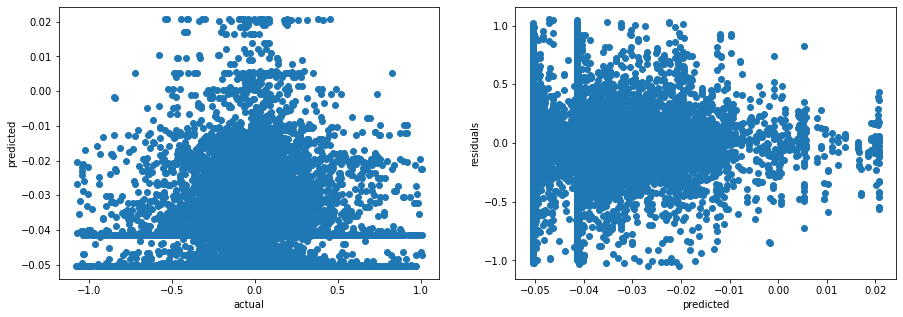

In [17]:
x_dat = dat_cong[['V', 'congruency']]
y_dat = dat_cong['pupil']


predicted = res.predict(x_dat)
residuals = y_dat - predicted

f, axs = plt.subplots(1, 2, figsize = [15,5])

axs[0].scatter(y_dat, predicted)
axs[0].set_xlabel('actual')
axs[0].set_ylabel('predicted')

axs[1].scatter(predicted, residuals)
axs[1].set_xlabel('predicted')
axs[1].set_ylabel('residuals')



**Check for Normality of residuals**

/var/folders/v4/1zbrx95516919mf320cfydlh0000gn/T/ipykernel_54493/1540356105.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals,kde=True)


Text(0.5, 1.0, 'Normality of error terms/residuals')

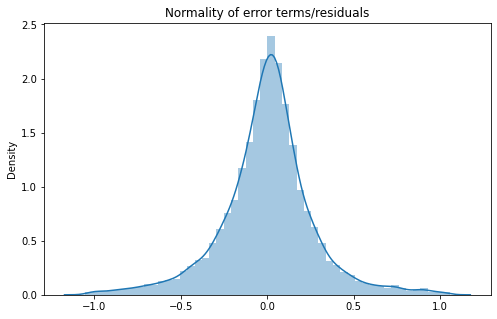

In [18]:
sns.distplot(residuals,kde=True)
plt.title('Normality of error terms/residuals')

## Pupil ~ V * timebin * congruency

In [19]:
i_ext = [False if (x is not str(x) and np.isnan(x)) else True for x in dat['congruency'].values]
dat_cong = dat[i_ext]

res = smf.ols("pupil ~ V*timebin*C(congruency, Treatment(reference = 'incongr'))", data = dat_cong).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  pupil   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     23.96
Date:                Mon, 27 Jan 2025   Prob (F-statistic):           1.85e-66
Time:                        22:09:43   Log-Likelihood:                -1363.2
No. Observations:               13921   AIC:                             2758.
Df Residuals:                   13905   BIC:                             2879.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 -0.0167      0.008     -2.187      0.029      -0.032      -0.002
timebin[T.t2]                                                             -0.1021      0.011     -9.424      0.000      -0.123      -0.081
timebin[T.t3]                                                             -0.0366      0.011     -3.380      0.001      -0.058      -0.015
timebin[T.t4]                                                              0.0033      0.011      0.302      0.763      -0.018       0.024
C(congruency, Treatment(reference='incongr'))[T.congr]                     0.0077      0.011      0.717      0.473      -0.013       0.029
timebin[T.t2]:C(congruency, Treatment(reference='incongr'))[T.congr]       0.0071      0.015      0.466      0.641      -0.023       0.037
timebin[T.t3]:C(congruency, Treatment(reference='incongr'))[T.congr]      -0.0013      0.015     -0.087      0.931      -0.031       0.029
timebin[T.t4]:C(congruency, Treatment(reference='incongr'))[T.congr]      -0.0008      0.015     -0.050      0.960      -0.031       0.029
V                                                                          0.0113      0.033      0.346      0.729      -0.053       0.075
V:timebin[T.t2]                                                            0.0842      0.046      1.821      0.069      -0.006       0.175
V:timebin[T.t3]                                                            0.0290      0.046      0.627      0.530      -0.062       0.120
V:timebin[T.t4]                                                            0.0654      0.046      1.413      0.158      -0.025       0.156
V:C(congruency, Treatment(reference='incongr'))[T.congr]                   0.0042      0.047      0.091      0.927      -0.087       0.096
V:timebin[T.t2]:C(congruency, Treatment(reference='incongr'))[T.congr]    -0.0565      0.066     -0.858      0.391      -0.186       0.073
V:timebin[T.t3]:C(congruency, Treatment(reference='incongr'))[T.congr]     0.0246      0.066      0.374      0.709      -0.105       0.154
V:timebin[T.t4]:C(congruency, Treatment(reference='incongr'))[T.congr]     0.0419      0.066      0.634      0.526      -0.088       0.171
==============================================================================
Omnibus:                      715.360   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2763.057
Skew:                          -0.043   Prob(JB):                         0.00
Kurtosis:                       5.181   Cond. No.                         65.4
===============================================

In [20]:
# Extract the p-values from the OLS regression result.
p_values = res.pvalues

# Perform multiple hypothesis testing correction on the p-values using the Benjamini-Hochberg method (FDR correction), with a significance level (alpha) of 0.05.
_, pvals_corrected, _, _ = statsmodels.stats.multitest.multipletests(p_values, alpha=0.05, method='fdr_bh')

# Convert the original and corrected p-values to a DataFrame for better visualization.
df_stats = pd.DataFrame(res.summary().tables[1])
df_stats.set_index(df_stats.columns[0], inplace=True)
df_stats.columns = df_stats.iloc[0]
df_stats = df_stats[1:]
df_stats.insert(6, "corrected", pvals_corrected)

# Save the DataFrame with original and corrected p-values to an Excel file.
df_stats.to_excel("output_pupil_V-timebin-congruency.xlsx")
df_stats

,coef,std err,t,P>|t|,[0.025,0.975],corrected
0,,,,,,,
Intercept,-0.0167,0.008,-2.187,0.029,-0.032,-0.002,1.532028e-01
timebin[T.t2],-0.1021,0.011,-9.424,0.000,-0.123,-0.081,8.041191e-20
timebin[T.t3],-0.0366,0.011,-3.380,0.001,-0.058,-0.015,5.817493e-03
timebin[T.t4],0.0033,0.011,0.302,0.763,-0.018,0.024,9.389537e-01
"C(congruency, Treatment(reference='incongr'))[T.congr]",0.0077,0.011,0.717,0.473,-0.013,0.029,9.389537e-01
"timebin[T.t2]:C(congruency, Treatment(reference='incongr'))[T.congr]",0.0071,0.015,0.466,0.641,-0.023,0.037,9.389537e-01
"timebin[T.t3]:C(congruency, Treatment(reference='incongr'))[T.congr]",-0.0013,0.015,-0.087,0.931,-0.031,0.029,9.597936e-01
"timebin[T.t4]:C(congruency, Treatment(reference='incongr'))[T.congr]",-0.0008,0.015,-0.050,0.960,-0.031,0.029,9.597936e-01
V,0.0113,0.033,0.346,0.729,-0.053,0.075,9.389537e-01


In [21]:
# Convert the original and corrected p-values to a DataFrame for better visualization.
df_stats = pd.DataFrame(res.summary().tables[0])
df_stats.set_index(df_stats.columns[0], inplace=True)
df_stats.columns = df_stats.iloc[0]
df_stats = df_stats[1:]
# Save the DataFrame to an Excel file.
df_stats.to_excel("output_model_param - pupil_V-timebin-congruency.xlsx", index = True)
df_stats

Dep. Variable:,pupil,R-squared:,0.025
0,,,
Model:,OLS,Adj. R-squared:,0.024
Method:,Least Squares,F-statistic:,23.96
Date:,"Mon, 27 Jan 2025",Prob (F-statistic):,1.85e-66
Time:,22:09:43,Log-Likelihood:,-1363.2
No. Observations:,13921,AIC:,2758.
Df Residuals:,13905,BIC:,2879.
Df Model:,15,,
Covariance Type:,nonrobust,,


### Assumption Check

**Check for Homoscedasticity**

Text(0, 0.5, 'residuals')

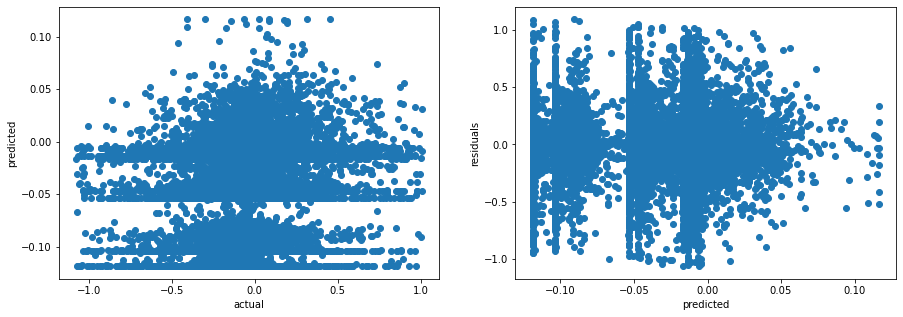

In [22]:
x_dat = dat_cong[['V', 'congruency', 'timebin']]
y_dat = dat_cong['pupil']


predicted = res.predict(x_dat)
residuals = y_dat - predicted

f, axs = plt.subplots(1, 2, figsize = [15,5])

axs[0].scatter(y_dat, predicted)
axs[0].set_xlabel('actual')
axs[0].set_ylabel('predicted')

axs[1].scatter(predicted, residuals)
axs[1].set_xlabel('predicted')
axs[1].set_ylabel('residuals')



**Check for Normality of residuals**

/var/folders/v4/1zbrx95516919mf320cfydlh0000gn/T/ipykernel_54493/1540356105.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals,kde=True)


Text(0.5, 1.0, 'Normality of error terms/residuals')

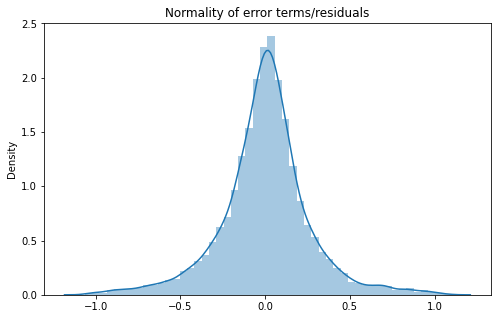

In [23]:
sns.distplot(residuals,kde=True)
plt.title('Normality of error terms/residuals')